<a href="https://colab.research.google.com/github/roderickperez/PINN/blob/master/PINN_SimpleODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN
Tutorial 2: Simple ODE 

Reference: Juan Toscano (Github: jdtoscano94)

https://github.com/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/2_SimpleODE.ipynb

## 0. Install Libraries

In [70]:
! pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Import Libraries

In [71]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

In [72]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

## 2. Setup parameters and constants

In [73]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [74]:
steps = 250
lr = 0.001

layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
min=0
max=2*np.pi
total_points=500


Nu = 2 #Nu: Number of training points (2 as we only have 2 boundaries)
Nf = 50 # Nf: Number of collocation points (Evaluate ODE)

## 3. Define Function

### ODE

What function has as a derivative $cos(X)$?

$$ y_{x}=\frac{dy}{dx}=cos(x) $$

Residual:

$$f_{x}=y_{x}-cos(x)$$

where $y_{x}$ is the output solution.

**Initial Conditions**

If we evaluate the function at 

* $x=0$

$$ y_{0} = cos(0) = 1 $$

$$f_{0} = y_{0}-cos(0) = 1 - 1 = 0$$

*  $x = 2\pi$

$$ y_{2\pi} = cos(2\pi) = 1 $$

$$f_{0} = y_{2\pi}-cos(2\pi) = 1 - 1 = 0$$

**Analytical solution of equation**
$$\int dy = \int cos(x) dx$$

$$y(x) = sin(x) + C $$

Since 

$$y(0) = 0 = sin(x) + C ⇒ C = 0$$

So, the function that has as a derivative $cos(X)$ is:

$$y(x) = sin(x)$$

This function satisfies the boundry conditions. The same as the real one (To ease the data generation), but we may not have it.

In [75]:
def f_BC(x):
  return torch.sin(x)

The PDE equation is used to get the residual in the Neural Network.

In [76]:
def PDE(x):
  return torch.cos(x)

## 4. Define Network Architecture

Following the PyTorch Network Architecture
```python
class networkName(nn.Module):

    def __init__(self, ...):
        super(networkName, self).__init__()
        # Define Network layers
        self.layer1 = nn.XXXX(...)
        self.layer2 = nn.XXXX(...)
        ...
        self.layern = nn.XXXX(...)

    def forward(self, x):
        out = self.layer1
        out = self.layer2
        ...
        out = self.layern

        return out

# Call the model
model = networkName(...)

# Define loss
loss = nn.XXXLoss()
```

In this case, we will follow the following architecture:

*   Activation Function: tanh
*   Loss Function: MSE
*   Initialise neural network as a list using `nn.Modulelist()`


In [77]:
class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC):
      loss_BC=self.loss_function(self.forward(x_BC),f_BC(x_BC))
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]
      loss_PDE=self.loss_function(f_x,PDE(g))
      return loss_PDE
      
    def loss(self,x_BC,x_PDE):
      loss_bc=self.lossBC(x_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    def closure(self):
        
        optimizer.zero_grad()
        loss = self.lossNN(x_train, y_train)
        loss.backward()       
        self.iter += 1
        if self.iter % 100 == 0:
            print(loss)
        return loss

## 5. Data

Generate the analytical solution over the full domain

In [78]:
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f_BC(x)
print('X tensor shape: ', x.shape)
print('Y tensor shape: ', y.shape)

X tensor shape:  torch.Size([500, 1])
Y tensor shape:  torch.Size([500, 1])


### Plot Results

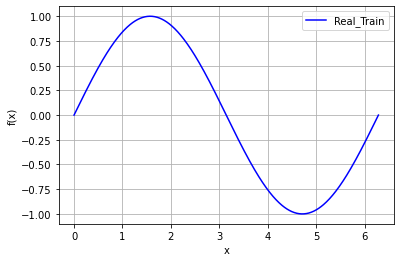

In [79]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper right')

### Set Boundary conditions:


Select the first and the last values of the evaluated function as a Boundary conditions.

In [80]:
BC_1=x[0,:]
BC_2=x[-1,:]

In [81]:
print('Location in x of Boundary Condition 1: ', BC_1.item())

Location in x of Boundary Condition 1:  0.0


In [82]:
print('Location in x of Boundary Condition 2: ', BC_2.item())

Location in x of Boundary Condition 2:  6.2831854820251465


### Total Training points
$$total = BC_{1}+BC_{2}$$


In [83]:
all_train = torch.vstack([BC_1,BC_2])

In [84]:
print('Total Boundary Condition Points: ', len(all_train))

Total Boundary Condition Points:  2


### Select Nu points


In [85]:
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]

In [86]:
print('Total Boundary Condition Points: ', len(x_BC))

Total Boundary Condition Points:  2


In [87]:
# Evaluate the Boundary Conditions in Function
x_BC=f_BC(x_BC).to(device)

In [88]:
print('Result of Evaluate Boundary Condition 1: ', x_BC[0].item())
print('Result of Evaluate Boundary Condition 2: ', x_BC[1].item())

Result of Evaluate Boundary Condition 1:  0.0
Result of Evaluate Boundary Condition 2:  1.7484555314695172e-07


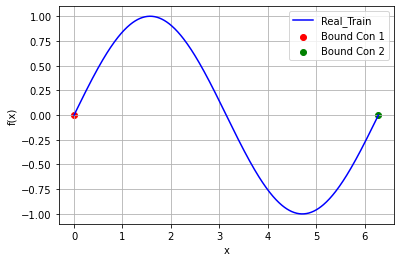

In [89]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.scatter(BC_1.detach().numpy(),x_BC[0],color='red',label='Bound Con 1')
ax1.scatter(BC_2.detach().numpy(),x_BC[1],color='green',label='Bound Con 2')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper right')

### Select Nf points

Note:

A Latin Hypercube (`lhs`) was used to sample collocation points 

In [90]:
# Positions in X to evaluate (Nf + BC)
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC))

Data points

`Nf` is the number of collocation points, corresponding to the number of points to evaluate the function.

In [91]:
print('Total Evaluation Points (X): ', x_PDE.shape[0])

Total Evaluation Points (X):  52


In [92]:
# Evaluate the Boundary Conditions in Function
y_PDE = f_BC(x_PDE).to(device)

In [93]:
print('Total Evaluated Points (Y): ', len(y_PDE))

Total Evaluated Points (Y):  52


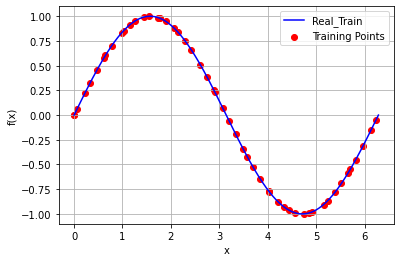

In [94]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.scatter(x_PDE.detach().numpy(),y_PDE.detach().numpy(),color='red',label='Training Points')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper right')

## 6. Train Network

In [95]:
# Prepare model
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)

In [96]:
len(x_PDE)

52

In [97]:
len(x_BC)

2

In [98]:
# Create Model and Show Summary
model = FCN(layers)
model.to(device)

print(model)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [99]:
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

In [100]:
len(x_PDE)

52

In [101]:
len(x_BC)

2

### 6.1 Training Loop

In [102]:
l = []

for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_PDE,x_BC) # use mean squared error
    l.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(1.3697, grad_fn=<AddBackward0>)
tensor(0.1971, grad_fn=<AddBackward0>)
tensor(0.1140, grad_fn=<AddBackward0>)
tensor(0.0936, grad_fn=<AddBackward0>)
tensor(0.0773, grad_fn=<AddBackward0>)
tensor(0.0639, grad_fn=<AddBackward0>)
tensor(0.0553, grad_fn=<AddBackward0>)
tensor(0.0488, grad_fn=<AddBackward0>)
tensor(0.0383, grad_fn=<AddBackward0>)
tensor(0.0197, grad_fn=<AddBackward0>)


## 6. Plot Functions

In [103]:
# Function
yh=model(x.to(device))
y=f_BC(x)

In [104]:
len(yh)

500

In [105]:
yh_=model(x_PDE.to(device))

In [106]:
len(yh_)

52

## Error


In [107]:
print(model.lossBC(x.to(device)))

tensor(0.0068, grad_fn=<MseLossBackward0>)


## Derivative

In [108]:
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

### Detach from GPU

In [109]:
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()

In [110]:
print('x_PDE size = ', len(x_PDE))
print('y_plot size = ', len(y_plot))
print('yh_plot size = ', len(yh_plot))
print('f_x_plot size = ', len(f_x_plot))

x_PDE size =  52
y_plot size =  500
yh_plot size =  500
f_x_plot size =  500


## 7. Plot Results

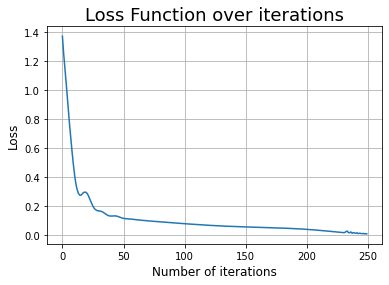

In [111]:
plt.plot(l)
plt.xlabel('Number of iterations', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Loss Function over iterations', fontsize = 18)
plt.grid()

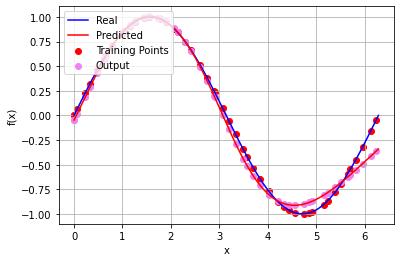

In [112]:
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
#ax1.plot(x,f_x_plot,color='green',label='Derivative')

ax1.scatter(x_PDE.detach().numpy(),y_PDE.detach().numpy(),color='red',label='Training Points')
ax1.scatter(x_PDE.detach().cpu().numpy(),yh_.detach().cpu().numpy(),color='violet',label='Output')

ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
ax1.grid()

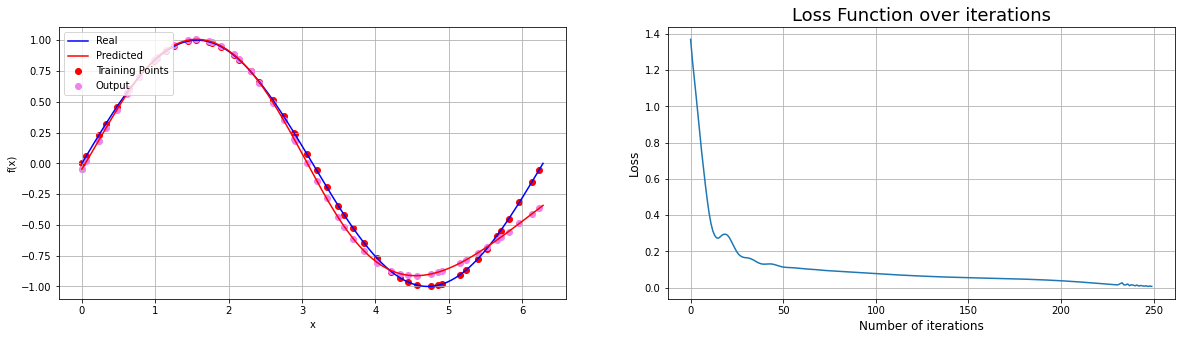

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(x,y_plot,color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
#ax1.plot(x,f_x_plot,color='green',label='Derivative')
ax1.scatter(x_PDE.detach().numpy(),y_PDE.detach().numpy(),color='red',label='Training Points')
ax1.scatter(x_PDE.detach().cpu().numpy(),yh_.detach().cpu().numpy(),color='violet',label='Output')

ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
ax1.grid()

##############
ax2.plot(l)
ax2.set_xlabel('Number of iterations', fontsize = 12)
ax2.set_ylabel('Loss', fontsize = 12)
ax2.set_title('Loss Function over iterations', fontsize = 18)
ax2.grid()